In [ ]:
# using Random
# using Statistics
# using DelimitedFiles
# using Printf
# using Distributions

In [1]:
mutable struct model

    np::Int64
    ns::Int64
    nexog::Int64
    ngh::Int64
    nvars::Int64
    nv::Int64
    nz::Int64
    pctrn::Float64
    mg::Float64
    mz::Float64
    mr::Float64
    damp::Float64
    tol::Float64

    yy::Array{Float64,2}
    T::Int64
    me::Array{Float64,1}

    xgrid::Array{Float64,2}
    bbt::Array{Float64,2}
    bbtinv::Array{Float64,2}
    slopecon::Array{Float64,2}
    coeffcn::Array{Float64,1}
    coeffpn::Array{Float64,1}
    coeffcb::Array{Float64,1}
    coeffpb::Array{Float64,1}

    model() = new()

end

In [20]:
function new_model()

    m = model()
    # number of variables
    m.np = 2
    m.ns = 4
    m.nexog = 3
    m.ngh = 3
    m.nvars = m.ns+m.nexog
    m.nv = 1+m.np*m.ns
    m.nz = m.ngh^m.nexog    

    m.pctrn = 0.05
    m.mg = 2.0
    m.mz = 2.0
    m.mr = 2.0

    m.damp = 0.7
    m.tol = 1e-5
    
#     m.yy = readdlm("./us.txt")
#     m.T = size(m.yy)[1]
#     m.me = zeros(3)
#     m.me[1] = std(m.yy[:,1]/100)*0.2
#     m.me[2] = std(m.yy[:,2]/100)*0.2
#     m.me[3] = std(m.yy[:,3]/100)*0.2

    return m

end

new_model (generic function with 1 method)

In [21]:
function qnwnorm1(n::Int64,mu::Float64,sigma::Float64)
# Originally from Fackler and Miranda's Compecon toolbox for MATLAB
# Copyright (c) 1997-2010, Paul L. Fackler & Mario J. Miranda

# Based on an algorithm in W.H. Press, S.A. Teukolsky, W.T. Vetterling
# and B.P. Flannery, "Numerical Recipes in FORTRAN", 2nd ed.  Cambridge
# University Press, 1992.
    maxit::Int64 = 100
    pim4::Float64 = 1/pi^0.25
    m::Int64 = floor((n+1)/2)
    x = zeros(Float64,n)
    w = zeros(Float64,n)
    z::Float64 = 0.0
    for i::Int64=1:m
        # Reasonable starting values
        if (i==1)
            z = sqrt(2*n+1)-1.85575*((2*n+1)^(-1/6))
        elseif (i==2)
            z = z-1.14*(n^0.426)/z
        elseif (i==3)
            z = 1.86*z+0.86*x[1]
        elseif (i==4)
            z = 1.91*z+0.91*x[2]
        else
            z = 2*z+x[i-2]
        end
        # root finding iterations
        its::Int64 = 0
        pp::Float64 = 0
        # type for p1,p2,p3,j,z1?
        # println([its maxit])
        while (its<maxit)
            its = its+1
            p1 = pim4
            p2 = 0
            for j=1:n
                p3 = p2
                p2 = p1
                p1 = z*sqrt(2/j)*p2-sqrt((j-1)/j)*p3
            end
            pp = sqrt(2*n)*p2
            # println([its pp])
            z1 = z
            z  = z1-p1/pp
            if (abs(z-z1)<1e-14)
                break
            end
        end
        # if its>=maxit
        #    error('failure to converge in qnwnorm1')
        # end
        x[n+1-i] = z
        x[i] = -z
        w[i] = 2/(pp*pp)
        w[n+1-i] = w[i]
    end
    # println(size(x))
    w = w/sqrt(pi)
    x = x*sqrt(2)

    x = mu*ones(Float64,n) + sigma*x

    return x, w

end

qnwnorm1 (generic function with 1 method)

In [22]:
function poly2s(xx,np,ns)

    nv = 1+np*ns
    f = zeros(1,nv)
    f[1] = 1.0

    for is = 1:ns

        x = xx[is]
        f[2*is] = x
        f[2*is+1] = 2*x^2-1

    end

    return f
end

poly2s (generic function with 1 method)

In [23]:
function makegrid(np,ns)

    nv = 1+np*ns
    xgrid = zeros(nv,ns)
    x = [0 -1 1]

    iv = 2

    for is=1:ns

        for ip=1:np

            xgrid[iv,is] = x[ip+1]
            iv = iv+1

        end

    end

    return xgrid
end

makegrid (generic function with 1 method)

In [24]:
function steadystate(para)

    # Theta = [tau kappa psi1 psi2 rA piA gammaQ rho_R rho_g rho_z sigma_R sigma_g sigma_z]
    invnu   = 6.0
    gyss    = 0.2
    tau     = para[1]
    kappa   = para[2]
    psi1    = para[3]
    psi2    = para[4]
    rA      = para[5]
    piA     = para[6]
    gammaQ  = para[7]
    rho_R   = para[8]
    rho_g   = para[9]
    rho_z   = para[10]
    sigma_R = para[11]/100
    sigma_g = para[12]/100
    sigma_z = para[13]/100

    gbar = 1.0/(1.0-gyss)
    bet  = 1/(1+rA/400)
    piss = 1+piA/400
    ass  = 1+gammaQ/100
    rnss = ass*piss/bet
    phi  = tau*(invnu-1)/piss^2/kappa # to be checked

    # variables rn0, c0, pi0, y0, rnot0, fc0, fp0, gnow, znow, rnow
    css  = (1.0-1.0/invnu)^(1.0/tau)
    yss  = gbar*css
    fcss = bet*css^(-tau)/ass/piss
    fpss = bet*phi*css^(-tau)*yss*(piss-piss)*piss

    ss = [rnss css piss yss rnss fcss fpss 0.0 0.0 0.0]

    return ss
end

steadystate (generic function with 1 method)

In [25]:
function pf(fc0,fp0,piss,invnu,tau,phi)

    try
        global c0 = fc0^(-1/tau)
    catch
        global c0 = 1.0 # css
        conv = false
    end
    # solve quadratic equation for pi
    a0 = .5*phi*piss^2*invnu + (1-invnu) + invnu*c0^tau + fp0*c0^tau
    a1 = -phi*piss*(1-invnu)
    a2 = -phi*(1-.5*invnu)
    try
        global pi0 = (a1-sqrt(a1^2-4*a0*a2))/2/a2
    catch
        global pi0 = piss
        conv = false
    end

    return c0,pi0

end

pf (generic function with 1 method)

In [26]:
function decr(endogvarm,shocks,para,slopecon,coeffcn,coeffpn,coeffcb,coeffpb,np,ns)

    # Theta = [tau kappa psi1 psi2 rA piA gammaQ rho_R rho_g rho_z sigma_R sigma_g sigma_z]
    invnu   = 6.0
    gyss    = 0.2
    tau     = para[1]
    kappa   = para[2]
    psi1    = para[3]
    psi2    = para[4]
    rA      = para[5]
    piA     = para[6]
    gammaQ  = para[7]
    rho_R   = para[8]
    rho_g   = para[9]
    rho_z   = para[10]
    sigma_R = para[11]/100
    sigma_g = para[12]/100
    sigma_z = para[13]/100

    gbar = 1/(1-gyss)
    bet  = 1/(1+rA/400)
    piss = 1+piA/400
    ass  = 1+gammaQ/100
    rnss = ass*piss/bet
    phi  = tau*(invnu-1)/piss^2/kappa # to be checked
    
    rn0 = endogvarm[1]
    gnow = endogvarm[8]
    znow = endogvarm[9]
    gp  = rho_g*gnow + sigma_g*shocks[1]
    zp  = rho_z*znow + sigma_z*shocks[2]
    rp  = sigma_R*shocks[3]
    ystar = (1-1/invnu)^(1/tau)*gbar*exp(gnow)

    xrn = slopecon[1,1]*rn0 + slopecon[1,2]
    xgp = slopecon[2,1]*gp + slopecon[2,2]
    xzp = slopecon[3,1]*zp + slopecon[3,2]
    xrp = slopecon[4,1]*rp + slopecon[4,2]

    # first assume the ZLB is not binding, and use coeffcn and coeffpn
    temp = poly2s([xrn xgp xzp xrp],np,ns)*coeffcn
    fc1 = temp[1]
    temp = poly2s([xrn xgp xzp xrp],np,ns)*coeffpn
    fp1 = temp[1]
    # next period's c and pi (obtained by next period's fc and fp)
    c1,pi1 = pf(fc1,fp1,piss,invnu,tau,phi)
    y1 = c1/(1/gbar/exp(gp) - phi/2*(pi1-piss)^2)
    try
        global rn1 = rn0^rho_R*( rnss*(pi1/piss)^psi1*(y1/ystar)^psi2 )^(1-rho_R)*exp(rp)
    catch
        global rn1 = rnss
        conv = false
    end

    endogvarp = [rn1 c1 pi1 y1 rn1 fc1 fp1 gp zp rp]

    # then check if the ZLB is violated by rn1, and use coeffcb and coeffpb instead
    if (rn1<1.0)

        temp = poly2s([xrn xgp xzp xrp],np,ns)*coeffcb
        fc1 = temp[1]
        temp = poly2s([xrn xgp xzp xrp],np,ns)*coeffpb
        fp1 = temp[1]

        # next period's c and pi (obtained by next period's fc and fp)
        c1,pi1 = pf(fc1,fp1,piss,invnu,tau,phi)
        y1 = c1/(1/gbar/exp(gp) - phi/2*(pi1-piss)^2)
        try
            global rn1 = rn0^rho_R*( rnss*(pi1/piss)^psi1*(y1/ystar)^psi2 )^(1-rho_R)*exp(rp)
        catch
            global rn1 = rnss
            conv = false
        end

#         endogvarp = [rn1 c1 pi1 y1 1.0 fc1 fp1 gp zp rp]
        endogvarp = [rn1 c1 pi1 y1 rn1 fc1 fp1 gp zp rp]

    end

    return endogvarp

end

decr (generic function with 1 method)

In [27]:
function solve(m,para)
    
    invnu   = 6.0
    gyss    = 0.2
    tau     = para[1]
    kappa   = para[2]
    psi1    = para[3]
    psi2    = para[4]
    rA      = para[5]
    piA     = para[6]
    gammaQ  = para[7]
    rho_R   = para[8]
    rho_g   = para[9]
    rho_z   = para[10]
    sigma_R = para[11]/100
    sigma_g = para[12]/100
    sigma_z = para[13]/100

    gbar = 1/(1-gyss)
    bet  = 1/(1+rA/400)
    piss = 1+piA/400
    ass  = 1+gammaQ/100
    rnss = ass*piss/bet
    phi  = tau*(invnu-1)/piss^2/kappa # to be checked

    # steady state values
    ss = steadystate(para)
    rnss = ss[1]
    css  = ss[2]
    piss = ss[3]
    yss  = ss[4]
    rnss = ss[5]
    fcss = ss[6]
    fpss = ss[7]

    # set up grid points
    m.xgrid = makegrid(m.np,m.ns)
    m.bbt = zeros(m.nv,m.nv)
    for iv = 1:m.nv

        m.bbt[iv,:] = poly2s(m.xgrid[iv,:],m.np,m.ns)

    end
    m.bbtinv = inv(m.bbt)

    # set bounds
    rnmin = (1-m.pctrn)*rnss
    rnmax = (1+m.pctrn)*rnss
    gmin = -m.mg*sigma_g/sqrt(1-rho_g^2)
    gmax = m.mg*sigma_g/sqrt(1-rho_g^2)
    zmin = -m.mz*sigma_z/sqrt(1-rho_z^2)
    zmax = m.mz*sigma_z/sqrt(1-rho_z^2)
    rmin = -m.mr*sigma_R
    rmax = m.mr*sigma_R

    m.slopecon = zeros(m.ns,2)
    m.slopecon[1,1] = 2/(rnmax-rnmin)
    m.slopecon[1,2] = -(rnmax+rnmin)/(rnmax-rnmin)
    m.slopecon[2,1] = 2/(gmax-gmin)
    m.slopecon[2,2] = -(gmax+gmin)/(gmax-gmin)
    m.slopecon[3,1] = 2/(zmax-zmin)
    m.slopecon[3,2] = -(zmax+zmin)/(zmax-zmin)
    m.slopecon[4,1] = 2/(rmax-rmin)
    m.slopecon[4,2] = -(rmax+rmin)/(rmax-rmin)

    # gh nodes and weights
    x,w = qnwnorm1(m.ngh,0.0,1.0)
    ghweights = zeros(m.nz)
    ghnodes = zeros(m.nz,m.nexog)
    for ir = 1:m.ngh

        for iz = 1:m.ngh

            for ig = 1:m.ngh

                index = m.ngh^2*(ir-1)+m.ngh*(iz-1)+ig
                ghweights[index] = w[ig]*w[iz]*w[ir]
                ghnodes[index,:] = [x[ig] x[iz] x[ir]]

            end

        end

    end


    # initial values
    # NOTE: We use an index-function approach with a pair of policy functions.
    # One assumes the ZLB always binds and the other assumes the ZLB never
    # binds. The next period's policy function is given by a weighted average
    # of the policy function in the ZLB regime and the policy function in the
    # non-ZLB regime with an indicator function. The value of the indicator
    # function is one when the notional rate is greater than the ZLB,
    # otherwise zero.
    cvec0n  = css*ones(m.nv)
    pivec0n = piss*ones(m.nv)
    rnvec0n = rnss*ones(m.nv)
    yvec0n  = yss*ones(m.nv)
    cvec0b  = css*ones(m.nv)
    pivec0b = piss*ones(m.nv)
    rnvec0b = rnss*ones(m.nv)
    yvec0b  = yss*ones(m.nv)
    cvec1n  = zeros(m.nv)
    pivec1n = zeros(m.nv)
    rnvec1n = zeros(m.nv)
    yvec1n  = zeros(m.nv)
    cvec1b  = zeros(m.nv)
    pivec1b = zeros(m.nv)
    rnvec1b = zeros(m.nv)
    yvec1b  = zeros(m.nv)

    fcvec0n = fcss*ones(m.nv)
    fpvec0n = fpss*ones(m.nv)
#     fcvec0b = bet*css^(-tau)/ass/piss*ones(m.nv) # assumes rn0 = 1.0
    fcvec0b = fcss*ones(m.nv) # assumes rn0 = 1.0
    fpvec0b = fpss*ones(m.nv)
    fcvec1n = zeros(m.nv)
    fpvec1n = zeros(m.nv)
    fcvec1b = zeros(m.nv)
    fpvec1b = zeros(m.nv)

    diff = 1e+4
    iter = 0
    global conv = true

    while ((diff>m.tol) && (iter<1000))

        # fitting polynomials
        m.coeffcn = m.bbtinv*fcvec0n
        m.coeffpn = m.bbtinv*fpvec0n
        m.coeffcb = m.bbtinv*fcvec0b
        m.coeffpb = m.bbtinv*fpvec0b

        for iv = 1:m.nv

            # variables rn0, c0, pi0, y0, rnot0, fc0, fp0, gnow, znow, rnow
            rnpast = (rnmax-rnmin)/2*m.xgrid[iv,1] + (rnmax+rnmin)/2
            gnow = (gmax-gmin)/2*m.xgrid[iv,2] + (gmax+gmin)/2
            znow = (zmax-zmin)/2*m.xgrid[iv,3] + (zmax+zmin)/2
            rnow = (rmax-rmin)/2*m.xgrid[iv,4] + (rmax+rmin)/2
            # natural output
            # BUG: it should be inside the expectation loop too
            ystar = (1-1/invnu)^(1/tau)*gbar*exp(gnow)

            # current period's c and pi (obtained by current period's fc and fp)
            # in the non-ZLB regime
            fc0n = fcvec0n[iv]
            fp0n = fpvec0n[iv]
            c0n,pi0n = pf(fc0n,fp0n,piss,invnu,tau,phi)
            y0n = c0n/(1/gbar/exp(gnow) - phi/2*(pi0n-piss)^2)
            try
                global rn0n = rnpast^rho_R*( rnss*(pi0n/piss)^psi1*(y0n/ystar)^psi2 )^(1-rho_R)*exp(rnow)
            catch
                global rn0n = rnss
                conv = false
            end
            endogvarn = [rn0n c0n pi0n y0n rn0n fc0n fp0n gnow znow rnow]

            # in the ZLB regime
            fc0b = fcvec0b[iv]
            fp0b = fpvec0b[iv]
            c0b,pi0b = pf(fc0b,fp0b,piss,invnu,tau,phi)
            y0b = c0b/(1/gbar/exp(gnow) - phi/2*(pi0b-piss)^2)
            try
                global rn0b = rnpast^rho_R*( rnss*(pi0b/piss)^psi1*(y0b/ystar)^psi2 )^(1-rho_R)*exp(rnow)
            catch
                global rn0b = rnss
                conv = false
            end
#             endogvarb = [rn0b c0b pi0b y0b 1.0 fc0b fp0b gnow znow rnow]
            endogvarb = [rn0b c0b pi0b y0b rn0b fc0b fp0b gnow znow rnow]

            # update the expectation terms fc and fp with interpolation
            fc0n = 0.0
            fp0n = 0.0
            fc0b = 0.0
            fp0b = 0.0
            for iz = 1:m.nz

                # in the non-ZLB regime
                endogvarp = decr(endogvarn,ghnodes[iz,:],para,m.slopecon,m.coeffcn,m.coeffpn,m.coeffcb,m.coeffpb,m.np,m.ns)

                c1n = endogvarp[2]
                pi1n = endogvarp[3]
                y1n = endogvarp[4]
                zp = endogvarp[9]
                fcxn = c1n^(-tau)*rn0n/(ass*exp(zp))/pi1n # NOTE: max operator is needed?
                fpxn = c1n^(-tau)*y1n*(pi1n-piss)*pi1n/y0n

                # in the ZLB regime
                endogvarp = decr(endogvarb,ghnodes[iz,:],para,m.slopecon,m.coeffcn,m.coeffpn,m.coeffcb,m.coeffpb,m.np,m.ns)

                c1b = endogvarp[2]
                pi1b = endogvarp[3]
                y1b = endogvarp[4]
                zp = endogvarp[9]
#                 fcxb = c1b^(-tau)*1.0/(ass*exp(zp))/pi1b
                fcxb = c1b^(-tau)*rn0b/(ass*exp(zp))/pi1b
                fpxb = c1b^(-tau)*y1b*(pi1b-piss)*pi1b/y0b

                fc0n = fc0n + ghweights[iz]*bet*fcxn
                fp0n = fp0n + ghweights[iz]*bet*phi*fpxn
                fc0b = fc0b + ghweights[iz]*bet*fcxb
                fp0b = fp0b + ghweights[iz]*bet*phi*fpxb

            end # for iz

            cvec1n[iv]  = c0n
            pivec1n[iv] = pi0n
            yvec1n[iv]  = y0n
            rnvec1n[iv] = rn0n
            fcvec1n[iv] = fc0n
            fpvec1n[iv] = fp0n

            cvec1b[iv]  = c0b
            pivec1b[iv] = pi0b
            yvec1b[iv]  = y0b
            rnvec1b[iv] = rn0b
            fcvec1b[iv] = fc0b
            fpvec1b[iv] = fp0b

        end # for iv

        # calculate the norm between the old and new policy functions
        diffcn = maximum(abs.(cvec1n-cvec0n))
        diffpn = maximum(abs.(pivec1n-pivec0n))
        diffrn = maximum(abs.(rnvec1n-rnvec0n))
        diffyn = maximum(abs.(yvec1n-yvec0n))
        diffn  = maximum([diffcn diffpn diffrn diffyn])

        diffcb = maximum(abs.(cvec1b-cvec0b))
        diffpb = maximum(abs.(pivec1b-pivec0b))
        diffrb = maximum(abs.(rnvec1b-rnvec0b))
        diffyb = maximum(abs.(yvec1b-yvec0b))
        diffb  = maximum([diffcb diffpb diffrb diffyb])

        diff = maximum([diffn diffb])

        # update the policy functions
        cvec0n  = m.damp*cvec0n  + (1.0-m.damp)*cvec1n
        pivec0n = m.damp*pivec0n + (1.0-m.damp)*pivec1n
        rnvec0n = m.damp*rnvec0n + (1.0-m.damp)*rnvec1n
        yvec0n  = m.damp*yvec0n  + (1.0-m.damp)*yvec1n
        fcvec0n = m.damp*fcvec0n + (1.0-m.damp)*fcvec1n
        fpvec0n = m.damp*fpvec0n + (1.0-m.damp)*fpvec1n

        cvec0b  = m.damp*cvec0b  + (1.0-m.damp)*cvec1b
        pivec0b = m.damp*pivec0b + (1.0-m.damp)*pivec1b
        rnvec0b = m.damp*rnvec0b + (1.0-m.damp)*rnvec1b
        yvec0b  = m.damp*yvec0b  + (1.0-m.damp)*yvec1b
        fcvec0b = m.damp*fcvec0b + (1.0-m.damp)*fcvec1b
        fpvec0b = m.damp*fpvec0b + (1.0-m.damp)*fpvec1b

        # counter for iterations
        iter = iter + 1

        println([iter diffn diffb])

        if (any(isnan,[fcvec0n fpvec0n fcvec0b fpvec0b])==true)
            conv = false
        end

        if (typeof([fcvec0n fpvec0n fcvec0b fpvec0b])==Array{Complex{Float64},2})
            conv = false
        end

        if (conv==false) break end

    end # while

    if (iter>=1000) conv = false end

    return conv
end

solve (generic function with 1 method)

In [28]:
para = [2.83 0.78 1.80 0.63 0.42 3.30 0.52 0.77 0.98 0.88 0.22 0.71 0.31]
m = new_model()
@time solve(m,para)

[1.0 0.0933844 0.0933844]
[2.0 0.0657832 0.0657832]
[3.0 0.0464966 0.0464966]
[4.0 0.0329627 0.0329627]
[5.0 0.0233842 0.0233842]
[6.0 0.0198745 0.0198745]
[7.0 0.0196216 0.0196216]
[8.0 0.0179547 0.0179547]
[9.0 0.0152532 0.0152532]
[10.0 0.0120757 0.0120757]
[11.0 0.00891432 0.00891432]
[12.0 0.00607953 0.00607953]
[13.0 0.00433997 0.00433997]
[14.0 0.0038749 0.0038749]
[15.0 0.00347551 0.00347551]
[16.0 0.00314134 0.00314134]
[17.0 0.00286617 0.00286617]
[18.0 0.0027426 0.0027426]
[19.0 0.002697 0.002697]
[20.0 0.00263983 0.00263983]
[21.0 0.00257339 0.00257339]
[22.0 0.00253773 0.00253773]
[23.0 0.00248437 0.00248437]
[24.0 0.00239309 0.00239309]
[25.0 0.00227656 0.00227656]
[26.0 0.00215561 0.00215561]
[27.0 0.00206261 0.00206261]
[28.0 0.00196842 0.00196842]
[29.0 0.0018737 0.0018737]
[30.0 0.00177904 0.00177904]
[31.0 0.00168499 0.00168499]
[32.0 0.00159202 0.00159202]
[33.0 0.00150055 0.00150055]
[34.0 0.00141095 0.00141095]
[35.0 0.00132356 0.00132356]
[36.0 0.00123862 0.00123

true

In [30]:
using Plots
include("linsol.jl")

T1,T0 = model_solution(para)

rho_g   = para[9]
rho_z   = para[10]
sigma_R = para[11]
sigma_g = para[12]
sigma_z = para[13]

# steady state values
ss = steadystate(para)
rnss = ss[1]
css  = ss[2]
piss = ss[3]
yss  = ss[4]
rnss = ss[5]
fcss = ss[6]
fpss = ss[7]

# set bounds
rnmin = (1-m.pctrn)*rnss
rnmax = (1+m.pctrn)*rnss
gmin = -m.mg*sigma_g/sqrt(1-rho_g^2)
gmax = m.mg*sigma_g/sqrt(1-rho_g^2)
zmin = -m.mz*sigma_z/sqrt(1-rho_z^2)
zmax = m.mz*sigma_z/sqrt(1-rho_z^2)
rmin = -m.mr*sigma_R
rmax = m.mr*sigma_R

rngrid = collect(LinRange(rnmin,rnmax,101))
ggrid = collect(LinRange(gmin,gmax,101))
zgrid = collect(LinRange(zmin,zmax,101))

rnvec = zeros(101)
pivec = zeros(101)
yvec  = zeros(101)

#     eq_1   = 1  #** (2.1) on \hat{y}(t) **/
#     eq_2   = 2  #** (2.1) on \hat{pi}(t) **/
#     eq_3   = 3  #** (2.1) on \hat{R}(t) **/
#     eq_4   = 4  #** \hat{y}(t-1) **/
#     eq_5   = 5  #** \hat{g} process **/
#     eq_6   = 6  #** \hat{z} process **/
#     eq_7   = 7  #** \hat{y} expectational error **/
#     eq_8   = 8  #** \hat{pi} expectational error **/

for i = 1:101
    
    rnpast = log(rngrid[i]/rnss)
#     gnow = ggrid[i]
    gnow = 0 #gmax/100
#     znow = zgrid[i]
    znow = zmax/100
    rnow = 0
    
    endogvarm = zeros(8)
    endogvarm[3] = rnpast
    endogvarm[5] = gnow
    endogvarm[6] = znow    
    shocks = zeros(3)
    endogvar = T1*endogvarm + T0*shocks #decr(endogvarm,shocks,para,m.slopecon,m.coeffcn,m.coeffpn,m.coeffcb,m.coeffpb,m.np,m.ns)
    
    rnvec[i] = endogvar[3]
    pivec[i] = endogvar[2]
    yvec[i] = endogvar[1]
    
end
    
rnvec_lin = rnvec
pivec_lin = pivec
yvec_lin = yvec;

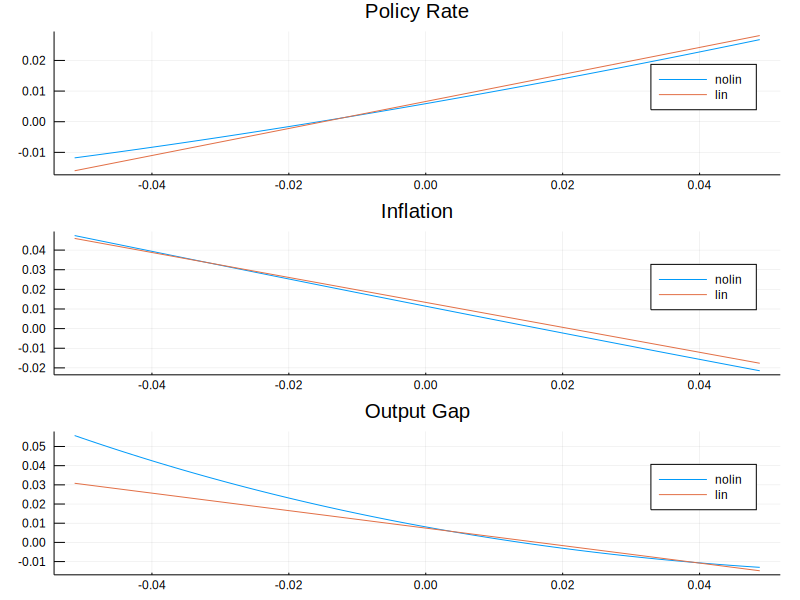

In [32]:
using Plots

rho_g   = para[9]
rho_z   = para[10]
sigma_R = para[11]/100
sigma_g = para[12]/100
sigma_z = para[13]/100

# steady state values
ss = steadystate(para)
rnss = ss[1]
css  = ss[2]
piss = ss[3]
yss  = ss[4]
rnss = ss[5]
fcss = ss[6]
fpss = ss[7]

# set bounds
rnmin = (1-m.pctrn)*rnss
rnmax = (1+m.pctrn)*rnss
gmin = -m.mg*sigma_g/sqrt(1-rho_g^2)
gmax = m.mg*sigma_g/sqrt(1-rho_g^2)
zmin = -m.mz*sigma_z/sqrt(1-rho_z^2)
zmax = m.mz*sigma_z/sqrt(1-rho_z^2)
rmin = -m.mr*sigma_R
rmax = m.mr*sigma_R

rngrid = collect(LinRange(rnmin,rnmax,101))
ggrid = collect(LinRange(gmin,gmax,101))
zgrid = collect(LinRange(zmin,zmax,101))

rnvec = zeros(101)
pivec = zeros(101)
yvec  = zeros(101)
cvec  = zeros(101)

for i = 1:101
    
    rnpast = rngrid[i]
#     gnow = ggrid[i]
    gnow = 0 #gmax
#     znow = zgrid[i]
    znow = zmax
    rnow = 0

    endogvarm = [rnpast css piss yss rnss fcss fpss gnow znow rnow]
    shocks = zeros(3)
    endogvar = decr(endogvarm,shocks,para,m.slopecon,m.coeffcn,m.coeffpn,m.coeffcb,m.coeffpb,m.np,m.ns)
    
    rnvec[i] = endogvar[5]
    pivec[i] = endogvar[3]
    yvec[i] = endogvar[4]
    cvec[i] = endogvar[2]
    
end

rnvec_nolin = log.(rnvec/rnss)
pivec_nolin = log.(pivec/piss)
yvec_nolin = log.(yvec/yss)

plot(
    plot(log.(rngrid/rnss),[rnvec_nolin rnvec_lin],title="Policy Rate"),
    plot(log.(rngrid/rnss),[pivec_nolin pivec_lin],title="Inflation"),
    plot(log.(rngrid/rnss),[yvec_nolin yvec_lin],title="Output Gap"),
    layout=(3,1),size=(800,600),label=["nolin" "lin"]
)